In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
# import necessary packages
seed_value = 0
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from measure_utils import *
from extract_feature_utils import *
import collections
np.random.seed(seed_value)
random.seed(seed_value)


In [2]:
def stat_analysis(thick_media, thick_intima):
    thick_wall = np.array([x + y if x >= 0 else x for x, y in zip(thick_media, thick_intima)])

    thick_media, thick_intima, thick_wall = post_process(thick_media, thick_intima, thick_wall)
    features_intima, features_media, features_ratio = extract_features(thick_media, thick_intima, thick_wall)
    row_features_label = {**features_media, **features_intima, **features_ratio}
        
    return thick_media, thick_intima, thick_wall, row_features_label

In [3]:
def get_cnts(img):
    gray_r = img[:, :, 0].copy()
    gray_g = img[:, :, 1].copy()
    gray_b = img[:, :, 2].copy()

    contours_r, hierarchy = cv2.findContours(gray_r, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours_g, hierarchy = cv2.findContours(gray_g, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours_b, hierarchy = cv2.findContours(gray_b, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    contours_r = [x.reshape(-1, 2) for x in contours_r]
    contours_g = [x.reshape(-1, 2) for x in contours_g]
    contours_b = [x.reshape(-1, 2) for x in contours_b]
    # Separate the contours
    return contours_r, contours_g, contours_b

In [4]:
def cnt_polygon_test(cnt1, cnt2):
    cnt1 = cnt1.reshape(-1, 2)
    cnt2 = cnt2.reshape(-1, 2)
    # check if cnt1 inside/cross cnt2    
    for point in cnt1:        
        if cv2.pointPolygonTest(cnt2, (int(point[0]), int(point[1])), False) >= 0: return True
    return False

def get_cnt_idx_w_largest_area(cnts):
    max_area = 0
    max_area_idx = 0
    for i in range(len(cnts)):
        curr_area = cv2.contourArea(cnts[i])
        if curr_area > max_area:
            max_area = curr_area
            max_area_idx = i
    return max_area_idx

def get_cnt_idx_intersecting_w_given_cnt(cnts, target):
    res_idx = None
    for i in range(len(cnts)):
        if cnt_polygon_test(target, cnts[i]):
            if res_idx is None:
                res_idx = i
            else:
                print("Sth Wrong")
    return res_idx

In [5]:
def plot_two_in_one_col(ax, img, thick_media, thick_intima, alpha, y_label=True, peak_indices=None):
    ax[0].imshow(img)
    ax[0].text(0, 50, r'$\lambda = $'+str(alpha), size=12, color='white', weight='bold')
    ax[0].axis('off')
    
    weights_outer = np.ones_like(thick_media)/float(len(thick_media))
    weights_inner = np.ones_like(thick_intima)/float(len(thick_intima))
#     bins = np.linspace(0, 1, 15)
#     ax[1].hist(thick_media, bins=bins, weights=weights_outer, alpha=0.5, label="Media")
#     ax[1].hist(thick_intima, bins=bins, weights=weights_inner, alpha=0.5, label="Intima")
#     ax[1].set_yticks(np.arange(0, 1.2, step=0.3))
#     ax[1].set_xlabel("Thickness", fontsize=12)

    ax[-1].plot([x if x>=0 else None for x in thick_media], label="Media")
    ax[-1].plot([x if x>=0 else None for x in thick_intima], label="Intima")
#     ax[-1].scatter(peak_indices, np.array(thick_intima)[peak_indices], marker="x")
    discard_samples = 0
    start = None
    for i, x in enumerate(thick_intima):
        if x < 0 and start is None:
            start = i
        elif x >= 0 and start is not None:
            discard_samples += 1
            if discard_samples == 1:
                ax[-1].axvspan(start, i-1, alpha=0.4, facecolor='gray', label="Discard")
            else:
                ax[-1].axvspan(start, i-1, alpha=0.4, facecolor='gray')
            start = None
    
    # If the last chunk of -2 goes until the end of the list
    if start is not None:
        ax[-1].axvspan(start, i, alpha=0.4, facecolor='gray')
     
    ax[-1].set_xlabel("Angle", fontsize=15)
    ax[-1].set_xticks(np.arange(0, 361, step=120), fontsize=12)
    if y_label:
        ax[-1].set_yticks(ticks=np.arange(0, 1.9, step=0.6), fontsize=12)
        ax[-1].set_ylabel("Thickness", fontsize=15)
        ax[-1].legend(fontsize=13, framealpha=0.5, loc='upper right')
    else:
        ax[-1].set_yticks(ticks=np.arange(0, 1.9, step=0.6), labels=[], fontsize=12)


def elastic_deformation(img, alpha, sigma=30):
    rows, cols = img.shape[:2]

    # Generate random displacement fields
    dx = np.random.randn(rows, cols) * alpha
    dy = np.random.randn(rows, cols) * alpha

    # Smooth the displacement fields
    dx = cv2.GaussianBlur(dx, (0, 0), sigma)
    dy = cv2.GaussianBlur(dy, (0, 0), sigma)

    # Calculate the distorted coordinates
    map_x, map_y = np.meshgrid(np.arange(cols), np.arange(rows))
    map_x = (map_x + dx).astype(np.float32)
    map_y = (map_y + dy).astype(np.float32)

    # Apply the deformation to the image
    deformed_img = cv2.remap(img, map_x, map_y, cv2.INTER_LINEAR)
    return deformed_img


def numerical_validation(img, step = 10):
    
    feature_changes = collections.defaultdict(list)
    
    fig, axs = plt.subplots(2, 7, figsize=(15, 4), gridspec_kw={'height_ratios':[3, 3]})
    for i in range(0, 1201, step):
        distorted_img = elastic_deformation(img, i)
        outer, middle, inner = get_cnts(distorted_img)
        outer_idx = get_cnt_idx_w_largest_area(outer)
        outer = outer[outer_idx]
        inner_idx = get_cnt_idx_w_largest_area(inner)
        middle_idx = get_cnt_idx_intersecting_w_given_cnt(middle, inner[inner_idx])
        exclude = middle[:middle_idx] + middle[middle_idx+1:]+ inner[:inner_idx] + inner[inner_idx+1:]
#         if len(exclude) > 0:
#             print(len(middle), len(inner))
#             print(exclude[0].shape)
#         print(exclude)
        thickness_outer, thickness_inner =  measure_thickness(outer.reshape(-1, 2), 
                                                                              middle[middle_idx].reshape(-1, 2), 
                                                                              inner[inner_idx].reshape(-1, 2), 
                                                                              angle_width=10, exclude=exclude,
                                                                                 vis=None,dir_save=None)
        
        thick_media, thick_intima, thick_wall, row_features_label = stat_analysis(thickness_outer, thickness_inner)
        for k in row_features_label:
            feature_changes[k].append(row_features_label[k])
        if i%200==0:
            peak_indices, peak_properties = circular_peaks(np.array(thick_intima), distance=1, width_threshold=10)
            if i == 0:
                plot_two_in_one_col(axs[:, i//200], distorted_img, thick_media, thick_intima, i,
                                    y_label="Thickness", peak_indices=peak_indices)
            else:
                plot_two_in_one_col(axs[:, i//200], distorted_img, thick_media, thick_intima, i, 
                                    y_label=False, peak_indices=peak_indices)
            print(np.max(thick_media), np.max(thick_intima))
    # Display the original and distorted images side by side
    plt.tight_layout()
    plt.show()
    return feature_changes

In [6]:
def plot_two_scales(feature_changes):
    
    
    
#     fig, ax1 = plt.subplots()
    t = range(len(feature_changes["Intima Average"]))
    
    for k in feature_changes:
        print(k, np.corrcoef(t, feature_changes[k])[0, 1])
#     color = 'tab:red'
#     ax1.scatter(t, feature_changes["Intima Average"], color=color)
# #     ax1.scatter(t, feature_changes["Intima Entropy"], color=color)    
#     ax1.tick_params(axis='y', labelcolor=color)
#     ax1.set_yticks(np.arange(0, 1.7, step=0.4), fontsize=12)
#     ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

#     color = 'tab:blue'
# #     ax2.plot(feature_changes["Intima Variance"], color=color)
#     ax2.plot(feature_changes["Intima Energy"], color=color)
#     ax2.tick_params(axis='y', labelcolor=color)

#     fig.tight_layout()  # otherwise the right y-label is slightly clipped
#     plt.show()

0.5011642126410614 0.5013642601520294
0.5400762922104504 0.5169353706771695
0.5324682166337098 0.5816120528237594
0.622489706913083 0.6368794777306537
0.6536774673467295 0.7121286011550303
0.6110368908870792 0.7082095051456211
0.8526976630267495 0.937469556529688


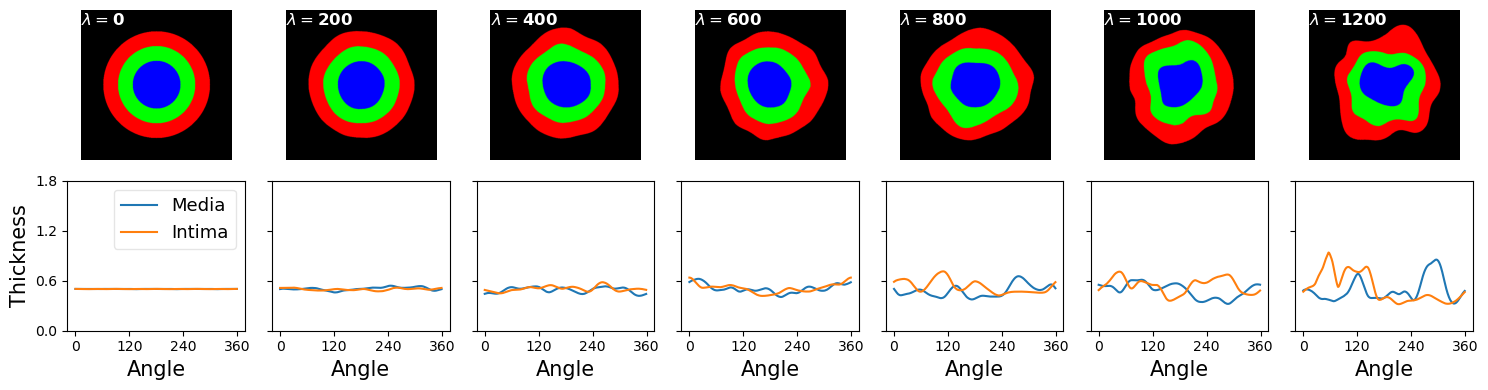

Media Peak Height 0.8058494741241371
Media Peak Prominence 0.8828664405546426
Media Average -0.05592598543749375
Media Median -0.19513007266153293
Media Variance 0.7818698541039426
Media Energy 0.8172956836618598
Intima Peak Height 0.7075920660577287
Intima Peak Prominence 0.8249000689721687
Intima Average 0.1446067389173075
Intima Median -0.1358252588209688
Intima Variance 0.6006596371529264
Intima Energy 0.6815445565706292
Ratio Peak Height 0.7350260967202896
Ratio Peak Prominence 0.833752319089081
Ratio Average 0.27437870734111064
Ratio Median 0.05499887067598604
Ratio Variance 0.6249518949443951
Ratio Energy 0.6826126487646126


In [7]:
# Create a black image with a white circle
img_full = np.zeros((512, 512, 3), np.uint8)
cv2.circle(img_full, (256, 256), 181, (255, 0, 0), -1)
cv2.circle(img_full, (256, 256), 131, (0, 255, 0), -1)
cv2.circle(img_full, (256, 256), 81, (0, 0, 255), -1)

feature_changes = numerical_validation(img_full)
plot_two_scales(feature_changes)

0.5347065173481297 0.5466626107436473
0.5411804522114257 0.5457319543952519
0.5380722480773505 0.5611649363548327
0.62195268258352 0.5847020368949075
0.5532618686954541 0.5915635358919213
0.510117706006542 0.7501495944949106
0.6144424229167393 0.7160795600815305


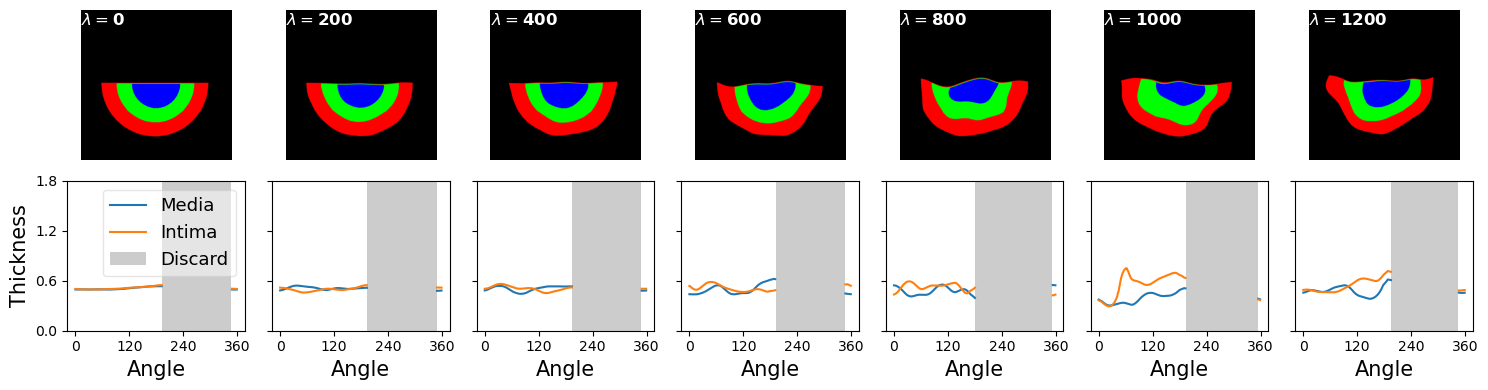

Media Peak Height 0.5730385100373986
Media Peak Prominence 0.7602998792218356
Media Average -0.31216790069094896
Media Median -0.2956940506035416
Media Variance 0.6144736918303848
Media Energy 0.4355787687994729
Intima Peak Height 0.7063316140859978
Intima Peak Prominence 0.7994896839479129
Intima Average 0.19406548991431768
Intima Median -0.003890928791359297
Intima Variance 0.6659779339291564
Intima Energy 0.5952316369963544
Ratio Peak Height 0.4371971276546989
Ratio Peak Prominence 0.36967242215682783
Ratio Average 0.4548558555162238
Ratio Median -0.5313616594929564
Ratio Variance 0.3376427720315594
Ratio Energy 0.21021024121276785


In [8]:
# Create a black image with a white circle
img_edge = np.zeros((512, 512, 3), np.uint8)
cv2.ellipse(img_edge, (250, 250), (181, 181), 0, 0, 180, (255, 0, 0), -1)
cv2.ellipse(img_edge, (252, 252), (131, 131), 0, 0, 180, (0, 255, 0), -1)
cv2.ellipse(img_edge, (254, 254), (81, 81), 0, 0, 180, (0, 0, 255), -1)

feature_changes = numerical_validation(img_edge)
plot_two_scales(feature_changes)

0.5297183056714614 0.99187531739359
0.5686846089994959 1.0617801433760459
0.6110593131864692 1.0258709151341159
0.7236878107873416 1.172400697968832
0.6419383462772917 0.8971081231393637
0.79132180186756 1.4027819561110182
0.7893069939253177 1.290132102229459


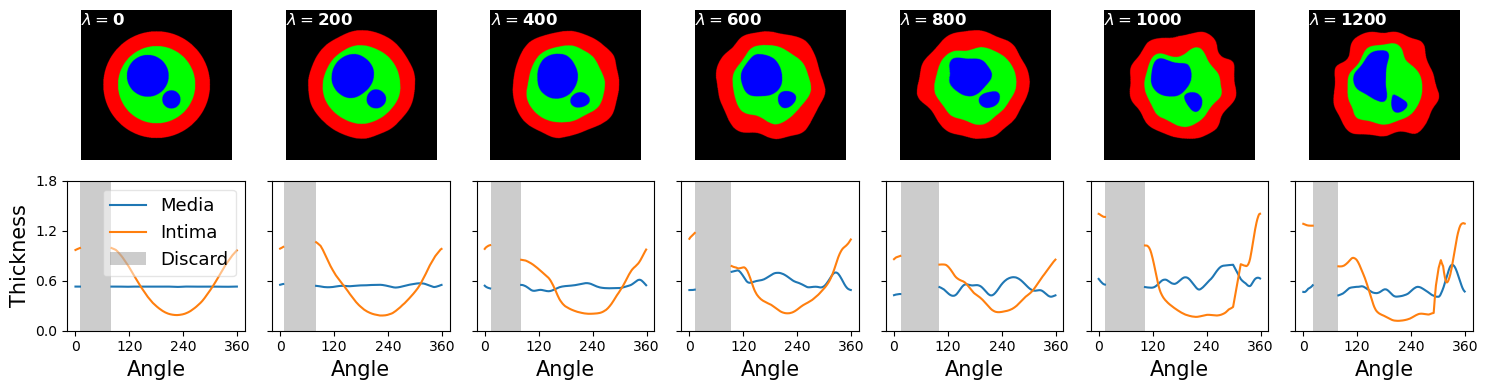

Media Peak Height 0.7491566136673331
Media Peak Prominence 0.87258670234187
Media Average 0.039683754099174566
Media Median -0.09864249362563451
Media Variance 0.6871845401364539
Media Energy 0.5131400794617871
Intima Peak Height 0.2378982430193118
Intima Peak Prominence -0.030738874007022295
Intima Average -0.17868701025729566
Intima Median -0.19269298549467498
Intima Variance 0.20488022120331117
Intima Energy 0.5285892888717365
Ratio Peak Height 0.46763894974310904
Ratio Peak Prominence 0.3117117862471409
Ratio Average -0.12602595831944843
Ratio Median -0.3261530057891505
Ratio Variance 0.3488959843491406
Ratio Energy 0.17351643288789817


In [9]:
# Create a black image with a white circle
img_full = np.zeros((512, 512, 3), np.uint8)
# cv2.circle(img_full, (256, 256), 151, (255, 0, 0), -1)
# cv2.circle(img_full, (256, 256), 121, (0, 255, 0), -1)
# cv2.circle(img_full, (216, 216), 51, (0, 0, 255), -1)
cv2.circle(img_full, (256, 256), 181, (255, 0, 0), -1)
cv2.circle(img_full, (256, 256), 131, (0, 255, 0), -1)
cv2.circle(img_full, (226, 226), 71, (0, 0, 255), -1)

cv2.circle(img_full, (306, 306), 31, (0, 0, 255), -1)
feature_changes = numerical_validation(img_full)
plot_two_scales(feature_changes)

(512, 512) (512, 512)
[[  0   1   2 ... 509 510 511]
 [  0   1   2 ... 509 510 511]
 [  0   1   2 ... 509 510 511]
 ...
 [  0   1   2 ... 509 510 511]
 [  0   1   2 ... 509 510 511]
 [  0   1   2 ... 509 510 511]] [[  0   0   0 ...   0   0   0]
 [  1   1   1 ...   1   1   1]
 [  2   2   2 ...   2   2   2]
 ...
 [509 509 509 ... 509 509 509]
 [510 510 510 ... 510 510 510]
 [511 511 511 ... 511 511 511]]


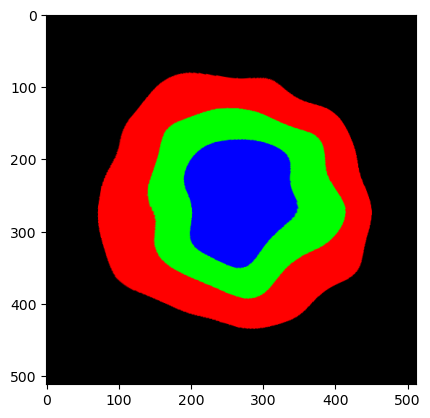

In [10]:
def elastic_deformation(img, alpha, sigma=30):
    rows, cols = img.shape[:2]

    # Generate random displacement fields
    dx = np.random.randn(rows, cols) * alpha
    dy = np.random.randn(rows, cols) * alpha
    print(dx.shape, dy.shape)

    # Smooth the displacement fields
    dx = cv2.GaussianBlur(dx, (0, 0), sigma)
    dy = cv2.GaussianBlur(dy, (0, 0), sigma)

    # Calculate the distorted coordinates
    map_x, map_y = np.meshgrid(np.arange(cols), np.arange(rows))
    print(map_x, map_y)
    map_x = (map_x + dx).astype(np.float32)
    map_y = (map_y + dy).astype(np.float32)

    # Apply the deformation to the image
    deformed_img = cv2.remap(img, map_x, map_y, cv2.INTER_LINEAR)
    return deformed_img

# Create a black image with a white circle
img_full = np.zeros((512, 512, 3), np.uint8)
cv2.circle(img_full, (256, 256), 181, (255, 0, 0), -1)
cv2.circle(img_full, (256, 256), 131, (0, 255, 0), -1)
cv2.circle(img_full, (256, 256), 81, (0, 0, 255), -1)

img_distorted = elastic_deformation(img_full, 1000)
plt.imshow(img_distorted)

In [11]:
def elastic_deformation(img, alpha, sigma=30):
    rows, cols = img.shape[:2]

    # Generate random displacement fields
    dx = np.random.randn(rows, cols) * alpha
    dy = np.random.randn(rows, cols) * alpha

    # Smooth the displacement fields
    dx = cv2.GaussianBlur(dx, (0, 0), sigma)
    dy = cv2.GaussianBlur(dy, (0, 0), sigma)

    # Calculate the distorted coordinates
    map_x, map_y = np.meshgrid(np.arange(cols), np.arange(rows))
    map_x = (map_x + dx).astype(np.float32)
    map_y = (map_y + dy).astype(np.float32)

    # Apply the deformation to the image
    deformed_img = cv2.remap(img, map_x, map_y, cv2.INTER_LINEAR)
    return deformed_img

for i in range(0, 10001, 10):
    img_full = np.zeros((512, 512, 3), np.uint8)
    cv2.circle(img_full, (256, 256), 181, (255, 0, 0), -1)
    cv2.circle(img_full, (256, 256), 131, (0, 255, 0), -1)
    cv2.circle(img_full, (256, 256), 81, (0, 0, 255), -1)

    img_distorted = elastic_deformation(img_full, 1000)
